# Multiple Plot

In [ ]:
import torch
from functorch import make_functional
from torch.func import functional_call, vmap, jacrev, jvp
    ## NUQLS
import posteriors.nuqls as nuqls
from importlib import reload
reload(nuqls)
from torch.utils.data import DataLoader, Dataset
import tqdm

class toy_dataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]
    
class variable_mlp(torch.nn.Module):
    def __init__(self,layer_width,nonlin):
        super().__init__()
        self.layer_width = layer_width
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_width[i],layer_width[i+1], bias=False) for i in range(len(self.layer_width)-1)])
        self.lin_out = torch.nn.Linear(self.layer_width[-1],1, bias=False)
        if nonlin=='tanh':
            self.act = torch.nn.Tanh()
        elif nonlin=='relu':
            self.act = torch.nn.ReLU()

        for lin in self.linear_layers:
            torch.nn.init.normal_(lin.weight, 0, 1)
        torch.nn.init.normal_(self.lin_out.weight, 0, 1)

    # Return full output of nn
    def forward(self,x):
        for i, lin in enumerate(self.linear_layers):
            x = self.act(lin(x)) / (self.layer_width[i]**0.5)
        return self.lin_out(x)

def convergence(n,d,layer_widths,nonlin,lr=1,verbose=False):
    X = torch.randn((n,d))
    Y = torch.randn((n,1))

    X_test = torch.randn((n,d))

    net = variable_mlp(layer_width=layer_widths,nonlin=nonlin)

    optimizer = torch.optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
    loss_fn = torch.nn.MSELoss()
    for i in range(5000):
        optimizer.zero_grad()
        pred = net(X)
        loss = loss_fn(pred,Y)
        loss.backward()
        optimizer.step()

    if verbose:
        print(f'nn loss : {loss.item():.4}')

    # Compute NTKGP
    fnet, params = make_functional(net)

    ## Compute jacobian of net, evaluated on training set
    def fnet_single(params, x):
        return fnet(params, x.unsqueeze(0)).squeeze(0)

    def Jx(Xs):
        J = vmap(jacrev(fnet_single), (None, 0))(params, Xs)
        J = [j.detach().flatten(1) for j in J]
        J = torch.cat(J,dim=1).detach()
        return J

    lam = 0
    Jtrain = Jx(X)
    NTK_X = Jtrain @ Jtrain.T + lam*torch.eye(n)
    cond = torch.linalg.cond(NTK_X).item()
    print(f'Cond(J J^T) = {cond:.1}')

    var_ntk = []
    for xi in X_test:
        Jsingle = Jx(xi.unsqueeze(0))
        KXx = Jtrain @ Jsingle.T
        var = Jsingle @ Jsingle.T - KXx.T @ torch.linalg.solve(NTK_X,KXx)
        var_ntk.append(var)
    var_ntk = torch.tensor(var_ntk)
    
    train_data = toy_dataset(X,Y)
    test_data = toy_dataset(X_test,Y)

    diff_e = []
    losses_e = []

    epochs = torch.logspace(1,4,10)
    for epoch in tqdm.tqdm(epochs):
        # nuql_test_preds, loss = nuqls.regression_parallel(net, train=train_data, test=test_data, ood_test=None, train_bs = n, test_bs =n, 
        #                                             S = 1000, scale=1, lr=8, epochs=int(epoch.item()), mu=0.9)
        
        nuql = nuqls.small_regression_parallel(net, train=train_data, S = 1000, epochs=int(epoch.item()), lr=lr, bs=n, bs_test=n, init_scale=1)
        loss,_ = nuql.train_linear(mu=0.9,weight_decay=0,my=0,sy=1,threshold=None,verbose=False, progress_bar=False)
        nuql_test_preds = nuql.test_linear(test=test_data)
        
        var_nuqls = nuql_test_preds.var(1)

        # print(f'epoch: {epoch}, convergence = {torch.linalg.norm(var_nuqls - var_ntk)}')
        diff_e.append(torch.linalg.norm(var_nuqls - var_ntk).item())
        losses_e.append(loss)
        if verbose:
            print('--------------------------------------')
            print(f'epoch: {int(epoch)}, nuqls loss : {loss.item():.4}')

    diff_s = []
    losses_s = []

    s_range = torch.logspace(1,4,10)
    for s in tqdm.tqdm(s_range):
        # nuql_test_preds, loss = nuqls.regression_parallel(net, train=train_data, test=test_data, ood_test=None, train_bs = n, test_bs =n, 
        #                                             S = int(s.item()), scale=1, lr=8, epochs=4000, mu=0.9)
        
        nuql = nuqls.small_regression_parallel(net, train=train_data, S = int(s.item()), epochs=4000, lr=lr, bs=n, bs_test=n, init_scale=1)
        loss,_ = nuql.train_linear(mu=0.9,weight_decay=0,my=0,sy=1,threshold=None,verbose=False, progress_bar=False)
        nuql_test_preds = nuql.test_linear(test=test_data)
        
        var_nuqls = nuql_test_preds.var(1)

        # print(f's: {s}, convergence = {torch.linalg.norm(var_nuqls - var_ntk)}')
        diff_s.append(torch.linalg.norm(var_nuqls - var_ntk).item())
        losses_s.append(loss)
        if verbose:
            print('--------------------------------------')
            print(f'S: {int(s)}, nuqls loss : {loss.item():.4}')

    return diff_e,losses_e,epochs,diff_s,losses_s,s_range,cond


In [ ]:
samples = 2
n = 100
d = 5
results_dict = {}

# single-layer, width=20, tanh
print(f'single-layer, width=20, tanh')
layer_widths = [d,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='tanh',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['tanh_single_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')

# single-layer, width=20, relu
print(f'single-layer, width=20, relu')
layer_widths = [d,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['relu_single_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')

# double-layer, width=20, relu
print(f'double-layer, width=20, relu')
layer_widths = [d,20,20]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='relu',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['relu_double_20'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')

# single-layer, width=100, tanh
print(f'single-layer, width=100, tanh')
layer_widths = [d,100]

diff_e_av = []
losses_e_av = []
diff_s_av = []
conds = []

for i in range(samples):
    diff_e,losses_e,epochs,diff_s,_,s_range,cond_i = convergence(n,d,layer_widths=layer_widths,nonlin='tanh',lr=0.1,verbose=True)
    diff_e_av.append(diff_e)
    losses_e_av.append(losses_e)
    diff_s_av.append(diff_s)
    conds.append(cond_i)

epoch_sev_avg = torch.tensor(diff_e_av).mean(0); epoch_sev_var = torch.tensor(diff_e_av).var(0)
epoch_loss_avg = torch.tensor(losses_e_av).mean(0); epoch_loss_var = torch.tensor(losses_e_av).var(0)
s_sev_avg = torch.tensor(diff_s_av).mean(0); s_sev_var = torch.tensor(diff_s_av).var(0)
cond_avg = torch.tensor(conds).mean(0)
results_dict['tanh_single_100'] = {'epoch_sev_avg': epoch_sev_avg,
                                  'epoch_sev_var': epoch_sev_var,
                                  'epoch_loss_avg': epoch_loss_avg,
                                  'epoch_loss_var': epoch_loss_var,
                                  's_sev_avg': s_sev_avg,
                                  's_sev_var': s_sev_var,
                                  'cond_avg': cond_avg,
                                  'epoch_range': epochs,
                                  's_range': s_range}
torch.save(results_dict,'paper/convergence_result_dict.pt')



single-layer, width=20, tanh


C:\Users\s4531973\AppData\Local\Temp\ipykernel_9080\475677823.py:84: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  fnet, params = make_functional(net)


nn loss : 0.002964
Cond(J J^T) = 9e+04


  0%|          | 0/10 [00:00<?, ?it/s]c:\Users\s4531973\Documents\PhD\Code\nuqls_paper\posteriors\nuqls.py:156: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  self.fnet, self.params = make_functional(self.net)
 30%|███       | 3/10 [00:00<00:00, 23.14it/s]

--------------------------------------
epoch: 10, nuqls loss : 5.727
--------------------------------------
epoch: 21, nuqls loss : 1.568
--------------------------------------
epoch: 46, nuqls loss : 0.1976
--------------------------------------
epoch: 100, nuqls loss : 0.04516
--------------------------------------
epoch: 215, nuqls loss : 0.019


 60%|██████    | 6/10 [00:01<00:00,  4.52it/s]

--------------------------------------
epoch: 464, nuqls loss : 0.008873
--------------------------------------
epoch: 1000, nuqls loss : 0.004923


 80%|████████  | 8/10 [00:05<00:01,  1.05it/s]

--------------------------------------
epoch: 2154, nuqls loss : 0.003278


 90%|█████████ | 9/10 [00:12<00:02,  2.07s/it]

--------------------------------------
epoch: 4641, nuqls loss : 0.00222


100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


--------------------------------------
epoch: 10000, nuqls loss : 0.001264


 10%|█         | 1/10 [00:03<00:31,  3.46s/it]

--------------------------------------
S: 10, nuqls loss : 0.00247


 20%|██        | 2/10 [00:07<00:28,  3.54s/it]

--------------------------------------
S: 21, nuqls loss : 0.002448


 30%|███       | 3/10 [00:10<00:24,  3.50s/it]

--------------------------------------
S: 46, nuqls loss : 0.002189


 40%|████      | 4/10 [00:14<00:21,  3.57s/it]

--------------------------------------
S: 100, nuqls loss : 0.002396


 50%|█████     | 5/10 [00:18<00:19,  3.99s/it]

--------------------------------------
S: 215, nuqls loss : 0.002337


 60%|██████    | 6/10 [00:27<00:22,  5.71s/it]

--------------------------------------
S: 464, nuqls loss : 0.002373


 70%|███████   | 7/10 [00:40<00:24,  8.02s/it]

--------------------------------------
S: 1000, nuqls loss : 0.002367


 80%|████████  | 8/10 [01:02<00:25, 12.51s/it]

--------------------------------------
S: 2154, nuqls loss : 0.002362


 90%|█████████ | 9/10 [01:44<00:21, 21.49s/it]

--------------------------------------
S: 4641, nuqls loss : 0.00238


100%|██████████| 10/10 [03:14<00:00, 19.45s/it]

--------------------------------------
S: 10000, nuqls loss : 0.002376


nn loss : 7.474e-05
Cond(J J^T) = 4e+04


 20%|██        | 2/10 [00:00<00:00, 14.96it/s]

--------------------------------------
epoch: 10, nuqls loss : 6.661
--------------------------------------
epoch: 21, nuqls loss : 1.42
--------------------------------------
epoch: 46, nuqls loss : 0.2015


 40%|████      | 4/10 [00:00<00:01,  4.76it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.03917


 50%|█████     | 5/10 [00:01<00:01,  2.60it/s]

--------------------------------------
epoch: 215, nuqls loss : 0.01465


 60%|██████    | 6/10 [00:03<00:02,  1.40it/s]

--------------------------------------
epoch: 464, nuqls loss : 0.005575


 70%|███████   | 7/10 [00:06<00:04,  1.49s/it]

--------------------------------------
epoch: 1000, nuqls loss : 0.001844


 80%|████████  | 8/10 [00:13<00:06,  3.12s/it]

--------------------------------------
epoch: 2154, nuqls loss : 0.0005507


 90%|█████████ | 9/10 [00:28<00:06,  6.65s/it]

--------------------------------------
epoch: 4641, nuqls loss : 0.0001459


100%|██████████| 10/10 [01:00<00:00,  6.00s/it]


--------------------------------------
epoch: 10000, nuqls loss : 2.595e-05


 10%|█         | 1/10 [00:03<00:32,  3.64s/it]

--------------------------------------
S: 10, nuqls loss : 0.0002948


 20%|██        | 2/10 [00:07<00:31,  3.96s/it]

--------------------------------------
S: 21, nuqls loss : 0.0002423


 30%|███       | 3/10 [00:11<00:25,  3.65s/it]

--------------------------------------
S: 46, nuqls loss : 0.00021


 40%|████      | 4/10 [00:14<00:21,  3.58s/it]

--------------------------------------
S: 100, nuqls loss : 0.0001794


 50%|█████     | 5/10 [00:19<00:20,  4.01s/it]

--------------------------------------
S: 215, nuqls loss : 0.0001931


 60%|██████    | 6/10 [00:28<00:22,  5.65s/it]

--------------------------------------
S: 464, nuqls loss : 0.0001931


 70%|███████   | 7/10 [00:34<00:17,  5.90s/it]

--------------------------------------
S: 1000, nuqls loss : 0.0001893


 80%|████████  | 8/10 [00:43<00:13,  6.79s/it]

--------------------------------------
S: 2154, nuqls loss : 0.0001956


 90%|█████████ | 9/10 [00:59<00:09,  9.87s/it]

--------------------------------------
S: 4641, nuqls loss : 0.00019


100%|██████████| 10/10 [01:35<00:00,  9.52s/it]

--------------------------------------
S: 10000, nuqls loss : 0.0001915
single-layer, width=20, relu


nn loss : 0.114
Cond(J J^T) = 3e+07


  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------
epoch: 10, nuqls loss : 24.91
--------------------------------------
epoch: 21, nuqls loss : 9.018
--------------------------------------
epoch: 46, nuqls loss : 0.606


 30%|███       | 3/10 [00:00<00:00, 22.48it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.04782
--------------------------------------
epoch: 215, nuqls loss : 0.02349


 60%|██████    | 6/10 [00:01<00:00,  4.27it/s]

--------------------------------------
epoch: 464, nuqls loss : 0.01427
--------------------------------------
epoch: 1000, nuqls loss : 0.01036


 80%|████████  | 8/10 [00:05<00:01,  1.06it/s]

--------------------------------------
epoch: 2154, nuqls loss : 0.007589


 90%|█████████ | 9/10 [00:12<00:02,  2.09s/it]

--------------------------------------
epoch: 4641, nuqls loss : 0.005055


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]


--------------------------------------
epoch: 10000, nuqls loss : 0.002754


 10%|█         | 1/10 [00:01<00:11,  1.23s/it]

--------------------------------------
S: 10, nuqls loss : 0.005438


 20%|██        | 2/10 [00:02<00:09,  1.22s/it]

--------------------------------------
S: 21, nuqls loss : 0.005558


 30%|███       | 3/10 [00:03<00:08,  1.27s/it]

--------------------------------------
S: 46, nuqls loss : 0.005558


 40%|████      | 4/10 [00:05<00:08,  1.38s/it]

--------------------------------------
S: 100, nuqls loss : 0.005654


 50%|█████     | 5/10 [00:07<00:07,  1.58s/it]

--------------------------------------
S: 215, nuqls loss : 0.005514


 60%|██████    | 6/10 [00:11<00:10,  2.60s/it]

--------------------------------------
S: 464, nuqls loss : 0.005587


 70%|███████   | 7/10 [00:17<00:10,  3.57s/it]

--------------------------------------
S: 1000, nuqls loss : 0.005563


 80%|████████  | 8/10 [00:26<00:10,  5.23s/it]

--------------------------------------
S: 2154, nuqls loss : 0.005553


 90%|█████████ | 9/10 [00:42<00:08,  8.84s/it]

--------------------------------------
S: 4641, nuqls loss : 0.005531


100%|██████████| 10/10 [01:19<00:00,  7.97s/it]

--------------------------------------
S: 10000, nuqls loss : 0.005541


nn loss : 0.04079
Cond(J J^T) = 2e+07


  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------
epoch: 10, nuqls loss : 37.05
--------------------------------------
epoch: 21, nuqls loss : 8.533
--------------------------------------
epoch: 46, nuqls loss : 0.9382


 30%|███       | 3/10 [00:00<00:00, 25.80it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.06397
--------------------------------------
epoch: 215, nuqls loss : 0.03996


 60%|██████    | 6/10 [00:01<00:00,  4.44it/s]

--------------------------------------
epoch: 464, nuqls loss : 0.03079
--------------------------------------
epoch: 1000, nuqls loss : 0.0254


 80%|████████  | 8/10 [00:05<00:01,  1.04it/s]

--------------------------------------
epoch: 2154, nuqls loss : 0.02102


 90%|█████████ | 9/10 [00:12<00:02,  2.18s/it]

--------------------------------------
epoch: 4641, nuqls loss : 0.01696


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]


--------------------------------------
epoch: 10000, nuqls loss : 0.01247


 10%|█         | 1/10 [00:01<00:11,  1.28s/it]

--------------------------------------
S: 10, nuqls loss : 0.01761


 20%|██        | 2/10 [00:02<00:10,  1.26s/it]

--------------------------------------
S: 21, nuqls loss : 0.01776


 30%|███       | 3/10 [00:03<00:09,  1.30s/it]

--------------------------------------
S: 46, nuqls loss : 0.01784


 40%|████      | 4/10 [00:05<00:08,  1.37s/it]

--------------------------------------
S: 100, nuqls loss : 0.01768


 50%|█████     | 5/10 [00:07<00:07,  1.59s/it]

--------------------------------------
S: 215, nuqls loss : 0.0178


 60%|██████    | 6/10 [00:12<00:10,  2.72s/it]

--------------------------------------
S: 464, nuqls loss : 0.01779


 70%|███████   | 7/10 [00:18<00:11,  3.96s/it]

--------------------------------------
S: 1000, nuqls loss : 0.01775


 80%|████████  | 8/10 [00:27<00:11,  5.63s/it]

--------------------------------------
S: 2154, nuqls loss : 0.01777


 90%|█████████ | 9/10 [00:45<00:09,  9.36s/it]

--------------------------------------
S: 4641, nuqls loss : 0.01773


100%|██████████| 10/10 [01:24<00:00,  8.40s/it]

--------------------------------------
S: 10000, nuqls loss : 0.01773
double-layer, width=20, relu


nn loss : 5.138e-12
Cond(J J^T) = 8e+03


  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------
epoch: 10, nuqls loss : 24.82


 20%|██        | 2/10 [00:00<00:00, 14.96it/s]

--------------------------------------
epoch: 21, nuqls loss : 5.421
--------------------------------------
epoch: 46, nuqls loss : 0.5893


 40%|████      | 4/10 [00:00<00:01,  5.72it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.01656


 50%|█████     | 5/10 [00:01<00:01,  2.94it/s]

--------------------------------------
epoch: 215, nuqls loss : 0.002688


 60%|██████    | 6/10 [00:02<00:02,  1.38it/s]

--------------------------------------
epoch: 464, nuqls loss : 0.0003497


 70%|███████   | 7/10 [00:06<00:04,  1.59s/it]

--------------------------------------
epoch: 1000, nuqls loss : 2.209e-05


 80%|████████  | 8/10 [00:14<00:06,  3.47s/it]

--------------------------------------
epoch: 2154, nuqls loss : 9.614e-08


 90%|█████████ | 9/10 [00:31<00:07,  7.50s/it]

--------------------------------------
epoch: 4641, nuqls loss : 8.432e-13


100%|██████████| 10/10 [01:08<00:00,  6.80s/it]


--------------------------------------
epoch: 10000, nuqls loss : 1.003e-23


 10%|█         | 1/10 [00:01<00:13,  1.47s/it]

--------------------------------------
S: 10, nuqls loss : 1.265e-11


 20%|██        | 2/10 [00:03<00:12,  1.54s/it]

--------------------------------------
S: 21, nuqls loss : 1.722e-11


 30%|███       | 3/10 [00:04<00:11,  1.69s/it]

--------------------------------------
S: 46, nuqls loss : 2.107e-11


 40%|████      | 4/10 [00:08<00:14,  2.42s/it]

--------------------------------------
S: 100, nuqls loss : 1.608e-11


 50%|█████     | 5/10 [00:12<00:15,  3.15s/it]

--------------------------------------
S: 215, nuqls loss : 1.999e-11


 60%|██████    | 6/10 [00:20<00:18,  4.66s/it]

--------------------------------------
S: 464, nuqls loss : 1.736e-11


 70%|███████   | 7/10 [00:34<00:23,  7.82s/it]

--------------------------------------
S: 1000, nuqls loss : 1.713e-11


 80%|████████  | 8/10 [01:03<00:29, 14.50s/it]

--------------------------------------
S: 2154, nuqls loss : 1.692e-11


 90%|█████████ | 9/10 [02:16<00:32, 32.65s/it]

--------------------------------------
S: 4641, nuqls loss : 1.681e-11


100%|██████████| 10/10 [06:23<00:00, 38.35s/it]

--------------------------------------
S: 10000, nuqls loss : 1.661e-11


nn loss : 8.587e-06
Cond(J J^T) = 2e+04


 10%|█         | 1/10 [00:00<00:01,  8.42it/s]

--------------------------------------
epoch: 10, nuqls loss : 19.18
--------------------------------------
epoch: 21, nuqls loss : 4.899


 30%|███       | 3/10 [00:00<00:01,  3.50it/s]

--------------------------------------
epoch: 46, nuqls loss : 0.4939


 40%|████      | 4/10 [00:01<00:03,  1.97it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.02218


 50%|█████     | 5/10 [00:03<00:04,  1.04it/s]

--------------------------------------
epoch: 215, nuqls loss : 0.004107


 60%|██████    | 6/10 [00:07<00:07,  1.92s/it]

--------------------------------------
epoch: 464, nuqls loss : 0.0008631


 70%|███████   | 7/10 [00:15<00:12,  4.05s/it]

--------------------------------------
epoch: 1000, nuqls loss : 0.0002001


 80%|████████  | 8/10 [00:33<00:16,  8.41s/it]

--------------------------------------
epoch: 2154, nuqls loss : 2.361e-05


 90%|█████████ | 9/10 [01:11<00:17, 17.75s/it]

--------------------------------------
epoch: 4641, nuqls loss : 3.415e-07


100%|██████████| 10/10 [02:33<00:00, 15.36s/it]


--------------------------------------
epoch: 10000, nuqls loss : 4.136e-11


 10%|█         | 1/10 [00:03<00:34,  3.78s/it]

--------------------------------------
S: 10, nuqls loss : 1.163e-06


 20%|██        | 2/10 [00:07<00:29,  3.74s/it]

--------------------------------------
S: 21, nuqls loss : 5.737e-07


 30%|███       | 3/10 [00:12<00:28,  4.14s/it]

--------------------------------------
S: 46, nuqls loss : 8.6e-07


 40%|████      | 4/10 [00:19<00:32,  5.46s/it]

--------------------------------------
S: 100, nuqls loss : 1.052e-06


 50%|█████     | 5/10 [00:30<00:37,  7.41s/it]

--------------------------------------
S: 215, nuqls loss : 1.057e-06


 60%|██████    | 6/10 [00:48<00:44, 11.03s/it]

--------------------------------------
S: 464, nuqls loss : 9.61e-07


 70%|███████   | 7/10 [01:21<00:54, 18.15s/it]

--------------------------------------
S: 1000, nuqls loss : 1.016e-06


 80%|████████  | 8/10 [02:31<01:09, 34.87s/it]

--------------------------------------
S: 2154, nuqls loss : 1.042e-06


 90%|█████████ | 9/10 [05:14<01:14, 74.85s/it]

--------------------------------------
S: 4641, nuqls loss : 1.012e-06


100%|██████████| 10/10 [10:53<00:00, 65.32s/it] 

--------------------------------------
S: 10000, nuqls loss : 9.918e-07
single-layer, width=100, tanh


nn loss : 5.165e-18
Cond(J J^T) = 3e+03


 10%|█         | 1/10 [00:00<00:01,  7.95it/s]

--------------------------------------
epoch: 10, nuqls loss : 4.693


 20%|██        | 2/10 [00:00<00:01,  5.27it/s]

--------------------------------------
epoch: 21, nuqls loss : 1.669


 30%|███       | 3/10 [00:00<00:02,  3.14it/s]

--------------------------------------
epoch: 46, nuqls loss : 0.2349


 40%|████      | 4/10 [00:01<00:03,  1.76it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.03862


 50%|█████     | 5/10 [00:03<00:05,  1.09s/it]

--------------------------------------
epoch: 215, nuqls loss : 0.01034


 60%|██████    | 6/10 [00:08<00:08,  2.21s/it]

--------------------------------------
epoch: 464, nuqls loss : 0.002059


 70%|███████   | 7/10 [00:17<00:13,  4.47s/it]

--------------------------------------
epoch: 1000, nuqls loss : 0.0001698


 80%|████████  | 8/10 [00:37<00:18,  9.35s/it]

--------------------------------------
epoch: 2154, nuqls loss : 2.04e-06


 90%|█████████ | 9/10 [01:19<00:19, 19.62s/it]

--------------------------------------
epoch: 4641, nuqls loss : 3.101e-10


100%|██████████| 10/10 [02:52<00:00, 17.26s/it]


--------------------------------------
epoch: 10000, nuqls loss : 4.535e-18


 10%|█         | 1/10 [00:03<00:32,  3.66s/it]

--------------------------------------
S: 10, nuqls loss : 6.1e-09


 20%|██        | 2/10 [00:07<00:31,  3.90s/it]

--------------------------------------
S: 21, nuqls loss : 4.229e-09


 30%|███       | 3/10 [00:12<00:31,  4.45s/it]

--------------------------------------
S: 46, nuqls loss : 2.766e-09


 40%|████      | 4/10 [00:20<00:35,  5.87s/it]

--------------------------------------
S: 100, nuqls loss : 3.069e-09


 50%|█████     | 5/10 [00:32<00:39,  7.96s/it]

--------------------------------------
S: 215, nuqls loss : 2.833e-09


 60%|██████    | 6/10 [00:52<00:48, 12.18s/it]

--------------------------------------
S: 464, nuqls loss : 2.77e-09


 70%|███████   | 7/10 [01:29<01:00, 20.18s/it]

--------------------------------------
S: 1000, nuqls loss : 2.786e-09


 80%|████████  | 8/10 [02:52<01:20, 40.08s/it]

--------------------------------------
S: 2154, nuqls loss : 2.875e-09


 90%|█████████ | 9/10 [05:52<01:23, 83.75s/it]

--------------------------------------
S: 4641, nuqls loss : 2.964e-09


100%|██████████| 10/10 [10:31<00:00, 63.17s/it] 

--------------------------------------
S: 10000, nuqls loss : 2.913e-09


nn loss : 1.733e-18
Cond(J J^T) = 4e+03


 10%|█         | 1/10 [00:00<00:01,  7.30it/s]

--------------------------------------
epoch: 10, nuqls loss : 4.748


 20%|██        | 2/10 [00:00<00:01,  5.03it/s]

--------------------------------------
epoch: 21, nuqls loss : 2.074


 30%|███       | 3/10 [00:00<00:02,  3.05it/s]

--------------------------------------
epoch: 46, nuqls loss : 0.2451


 40%|████      | 4/10 [00:01<00:03,  1.69it/s]

--------------------------------------
epoch: 100, nuqls loss : 0.04029


 50%|█████     | 5/10 [00:03<00:05,  1.10s/it]

--------------------------------------
epoch: 215, nuqls loss : 0.009877


 60%|██████    | 6/10 [00:08<00:08,  2.22s/it]

--------------------------------------
epoch: 464, nuqls loss : 0.00178


 70%|███████   | 7/10 [00:17<00:13,  4.51s/it]

--------------------------------------
epoch: 1000, nuqls loss : 0.0001788


 80%|████████  | 8/10 [00:37<00:19,  9.59s/it]

--------------------------------------
epoch: 2154, nuqls loss : 4.441e-06


 90%|█████████ | 9/10 [01:20<00:19, 19.99s/it]

--------------------------------------
epoch: 4641, nuqls loss : 3.663e-09


100%|██████████| 10/10 [02:53<00:00, 17.34s/it]


--------------------------------------
epoch: 10000, nuqls loss : 1.314e-15


 10%|█         | 1/10 [00:03<00:32,  3.62s/it]

--------------------------------------
S: 10, nuqls loss : 3.459e-08


 20%|██        | 2/10 [00:07<00:30,  3.86s/it]

--------------------------------------
S: 21, nuqls loss : 2.309e-08


 30%|███       | 3/10 [00:12<00:31,  4.43s/it]

--------------------------------------
S: 46, nuqls loss : 1.932e-08


 40%|████      | 4/10 [00:20<00:35,  5.87s/it]

--------------------------------------
S: 100, nuqls loss : 2.158e-08


 50%|█████     | 5/10 [00:32<00:40,  8.09s/it]

--------------------------------------
S: 215, nuqls loss : 2.513e-08


 60%|██████    | 6/10 [00:53<00:48, 12.25s/it]

--------------------------------------
S: 464, nuqls loss : 2.324e-08


 70%|███████   | 7/10 [01:30<01:01, 20.37s/it]

--------------------------------------
S: 1000, nuqls loss : 2.184e-08


 80%|████████  | 8/10 [02:53<01:21, 40.52s/it]

--------------------------------------
S: 2154, nuqls loss : 2.227e-08


 90%|█████████ | 9/10 [05:39<01:19, 79.47s/it]

--------------------------------------
S: 4641, nuqls loss : 2.204e-08


100%|██████████| 10/10 [12:09<00:00, 72.94s/it] 

--------------------------------------
S: 10000, nuqls loss : 2.196e-08


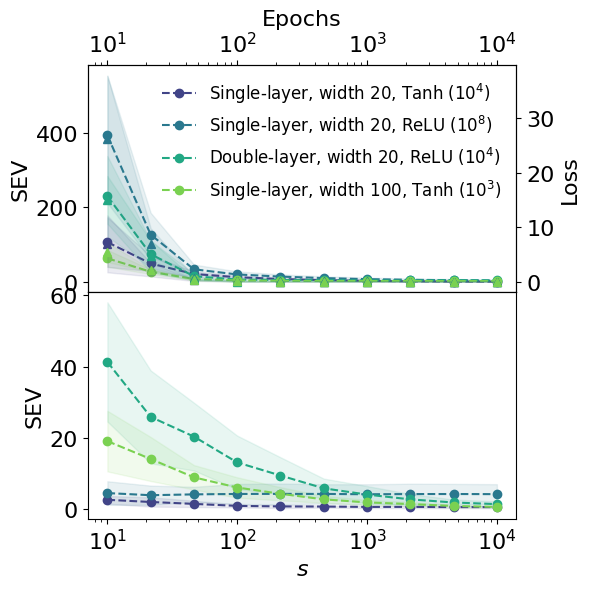

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm
import torch
from math import floor,log10

results_dict = torch.load('paper/convergence_result_dict.pt')

label_dict = {'tanh_single_20': 'Single-layer, width 20, Tanh',
              'relu_single_20': 'Single-layer, width 20, ReLU',
              'relu_double_20': 'Double-layer, width 20, ReLU',
              'tanh_single_100': 'Single-layer, width 100, Tanh'}

w, h, fs = 6, 6, 16
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(w,h),frameon=True,)
# color = cm.rainbow(np.linspace(0, 1, 4))

color = plt.cm.viridis(np.linspace(0.2,0.8,4))

ax1t = ax1.twinx()
ax1.set_ylabel('SEV', fontsize=fs)
ax1.set_xlabel('Epochs', fontsize=fs)
ax1.tick_params(labelsize=fs)
ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1t.spines['right'].set_visible(True)
ax1t.spines['top'].set_visible(True)
ax1t.set_ylabel('Loss', fontsize=fs)
ax1t.set_xscale('log')
ax1t.tick_params(labelsize=fs)
ax2.set_ylabel('SEV', fontsize=fs)
ax2.set_xlabel('$s$', fontsize=fs)
ax2.set_xscale('log')
ax2.tick_params(labelsize=fs)

for i,key in enumerate(results_dict.keys()):
    exponent = int(floor(log10(abs(results_dict[key]['cond_avg']))))
    ax1.plot(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_sev_avg'],
             color=color[i],marker='o',linestyle='dashed',
             label=label_dict[key] + f" ($10^{exponent}$)"
    )
    ax1.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_sev_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
             results_dict[key]['epoch_sev_avg'] + 1.96 * np.sqrt(results_dict[key]['epoch_sev_var']),
             color=color[i],alpha=0.1)
    
    ax1t.plot(results_dict[key]['epoch_range'],
              results_dict[key]['epoch_loss_avg'],
              color=color[i],marker='^',linestyle='none')
    ax1t.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['epoch_loss_avg'] - 1.96 * np.sqrt(results_dict[key]['epoch_loss_var']),
             results_dict[key]['epoch_loss_avg'] + 1.96 * np.sqrt(results_dict[key]['epoch_loss_var']),
             color=color[i],alpha=0.1)
    
    ax2.plot(results_dict[key]['s_range'],
             results_dict[key]['s_sev_avg'],color=color[i],marker='o',linestyle='dashed',)
    ax2.fill_between(results_dict[key]['epoch_range'],
             results_dict[key]['s_sev_avg'] - 1.96 * np.sqrt(results_dict[key]['s_sev_var']),
             results_dict[key]['s_sev_avg'] + 1.96 * np.sqrt(results_dict[key]['s_sev_var']),
             color=color[i],alpha=0.1)

ax1.legend(fontsize=int(fs * 0.75), frameon=False)
fig.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(fname='paper/epochs_ntk_convergence.pdf', format='pdf')